# Urbanization level clustering

In [83]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from src.config import CLUSTERING_CONFIGS, MASTER_DF_FILE, RANDOM_SEED, YEARS
from src.data.loader import DataLoader
from src.features.dimentionality import UrbanizationAnalyzer
from src.models.clustering import ClusteringEngine


warnings.filterwarnings("ignore")
# sns.set_style("whitegrid")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experiment with all the municipalities

In [84]:
EXP_KEY = "urban"
config = CLUSTERING_CONFIGS[EXP_KEY]

In [85]:
df = DataLoader(MASTER_DF_FILE).load_dataset(features=config["features"])
df2022 = DataLoader(MASTER_DF_FILE).get_data_for_year(year=2022, features=config["features"])
# df2023 = DataLoader(MASTER_DF_FILE).get_data_for_year(year=2023, features=config["features"])

2025-12-13 22:46:34,024 - INFO - Successfully loaded dataset with 3961 rows.
2025-12-13 22:46:34,048 - INFO - Retrieved 932 rows for year 2022.


### PCA

We categorize regions into distinct **Urbanization Tiers** by clustering on three core dimensions: **Service Availability**, **Income**, and **Population Density**.

To visualize the structure of this high-dimensional feature space, we project the data onto its first two Principal Components:
* **PC1 (Infrastructure):** Driven primarily by service availability columns.
* **PC2 (Wealth & Density):** Heavily weighted by income levels and population density.

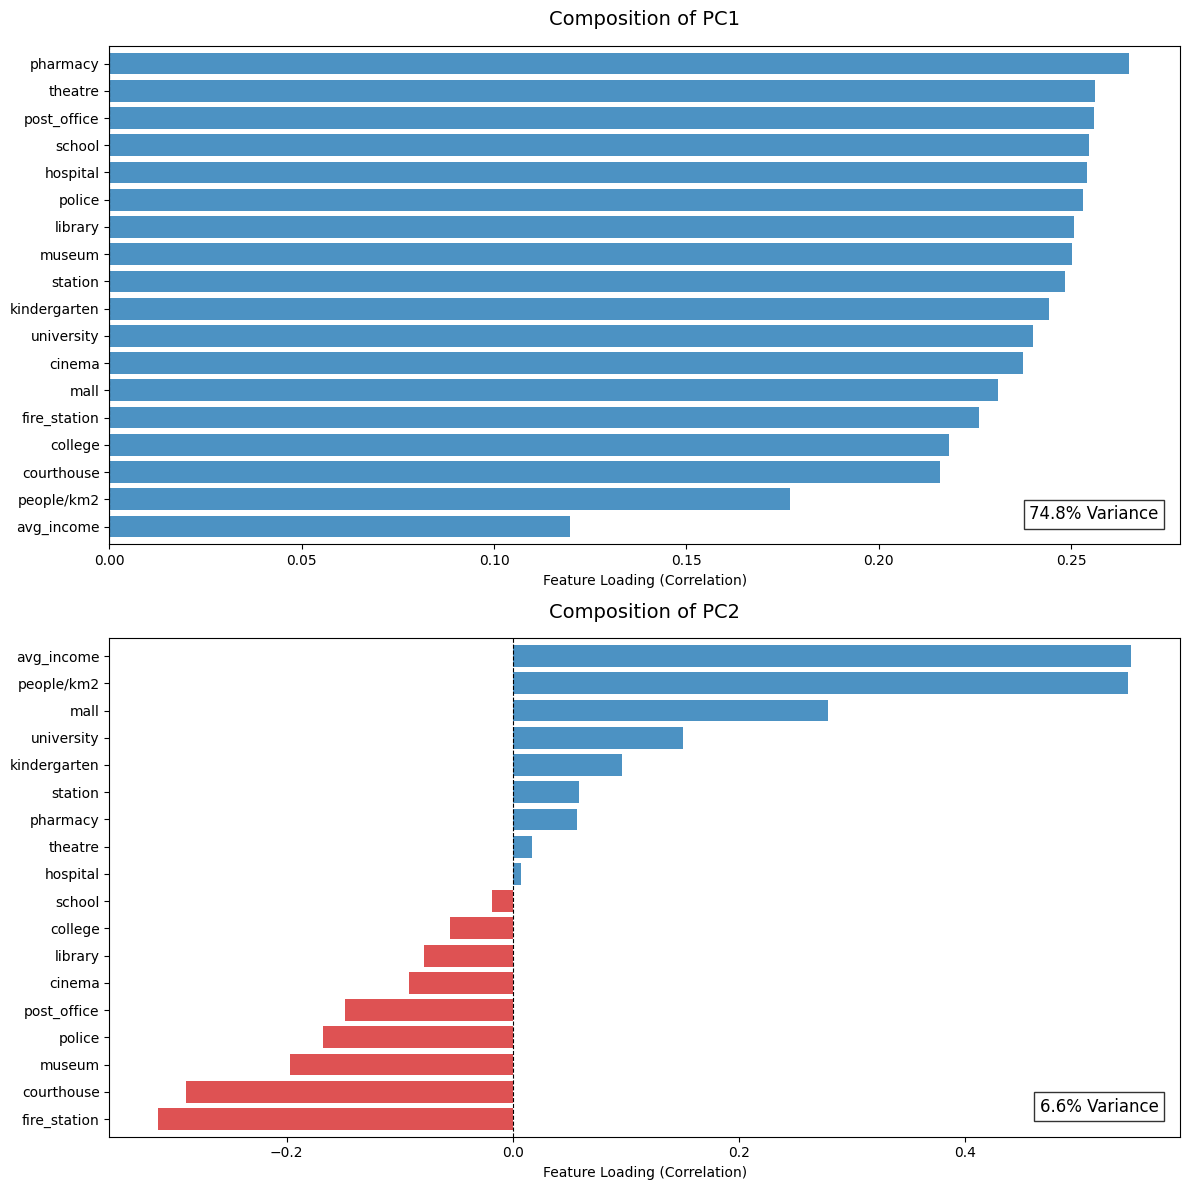

In [86]:
pca_engine = UrbanizationAnalyzer(n_components=2)
pca_df = pca_engine.run_pca(df)
pca_engine.plot_component_details().show()

We apply Principal Component Analysis (PCA) independently to each year's dataset to observe how the relationship between Infrastructure (PC1) and Wealth/Density (PC2) evolves over time.

We've observed:

- Structural Stability: The geometry of the projection remains largely consistent across all four years. This indicates that the fundamental correlation between a city's wealth and its available infrastructure is a stable, intrinsic characteristic of the region, not a transient fluctuation.

- Dominant Drivers: The first two components consistently capture a significant majority of the variance (typically >80%), confirming that "Infrastructure" and "Wealth" are indeed the primary forces shaping these urban environments.

- Yearly Consistency: The absence of radical shifts in the scatter plot distribution suggests no sudden structural breaks (e.g., a sudden decoupling of wealth from services) occurred during this period.

2025-12-13 22:46:34,548 - INFO - Retrieved 932 rows for year 2020.
2025-12-13 22:46:34,592 - INFO - Retrieved 932 rows for year 2021.
2025-12-13 22:46:34,636 - INFO - Retrieved 932 rows for year 2022.
2025-12-13 22:46:34,681 - INFO - Retrieved 932 rows for year 2023.


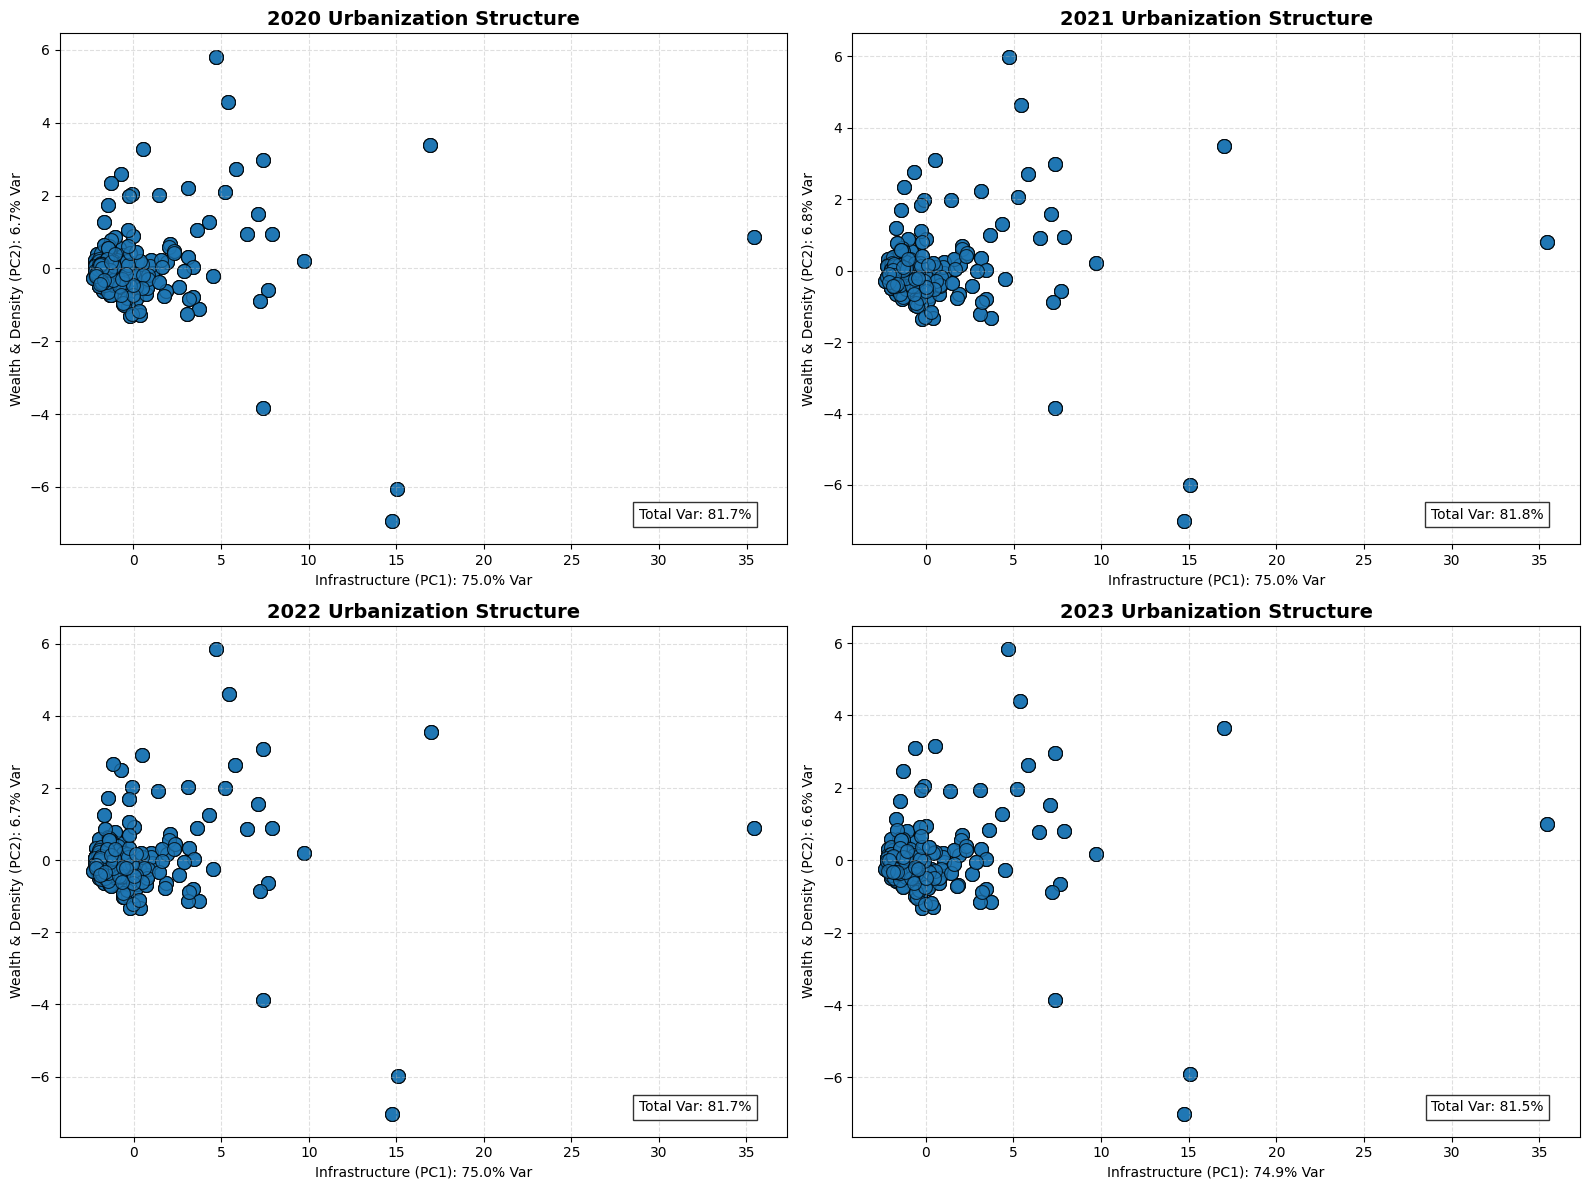

In [87]:
loader = DataLoader(MASTER_DF_FILE)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten to make indexing (0, 1, 2, 3) easier

for i, year in enumerate(YEARS):
    ax = axes[i]
    
    try:
        df_year = loader.get_data_for_year(year, features=config["features"])
        
        if df_year.empty:
            ax.text(0.5, 0.5, f"No Data for {year}", ha='center', fontsize=14)
            continue

        analyzer = UrbanizationAnalyzer(n_components=2)
        pca_tmp_df = analyzer.run_pca(df_year)
        stats = analyzer.get_variance_stats()
        
        sns.scatterplot(
            x='PC1', 
            y='PC2', 
            data=pca_tmp_df, 
            ax=ax, 
            s=100, 
            alpha=0.7, 
            edgecolor='k',
            legend=False
        )
        
        ax.set_title(f"{year} Urbanization Structure", fontsize=14, weight='bold')
        ax.set_xlabel(f"Infrastructure (PC1): {stats['pc1_var']:.1f}% Var")
        ax.set_ylabel(f"Wealth & Density (PC2): {stats['pc2_var']:.1f}% Var")
        ax.grid(True, linestyle="--", alpha=0.4)
        
        # Add total variance annotation
        ax.text(0.95, 0.05, f"Total Var: {stats['total_var']:.1f}%", 
                transform=ax.transAxes, ha='right', fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.8))

    except Exception as e:
        ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center', color='red')

plt.tight_layout()
plt.show()

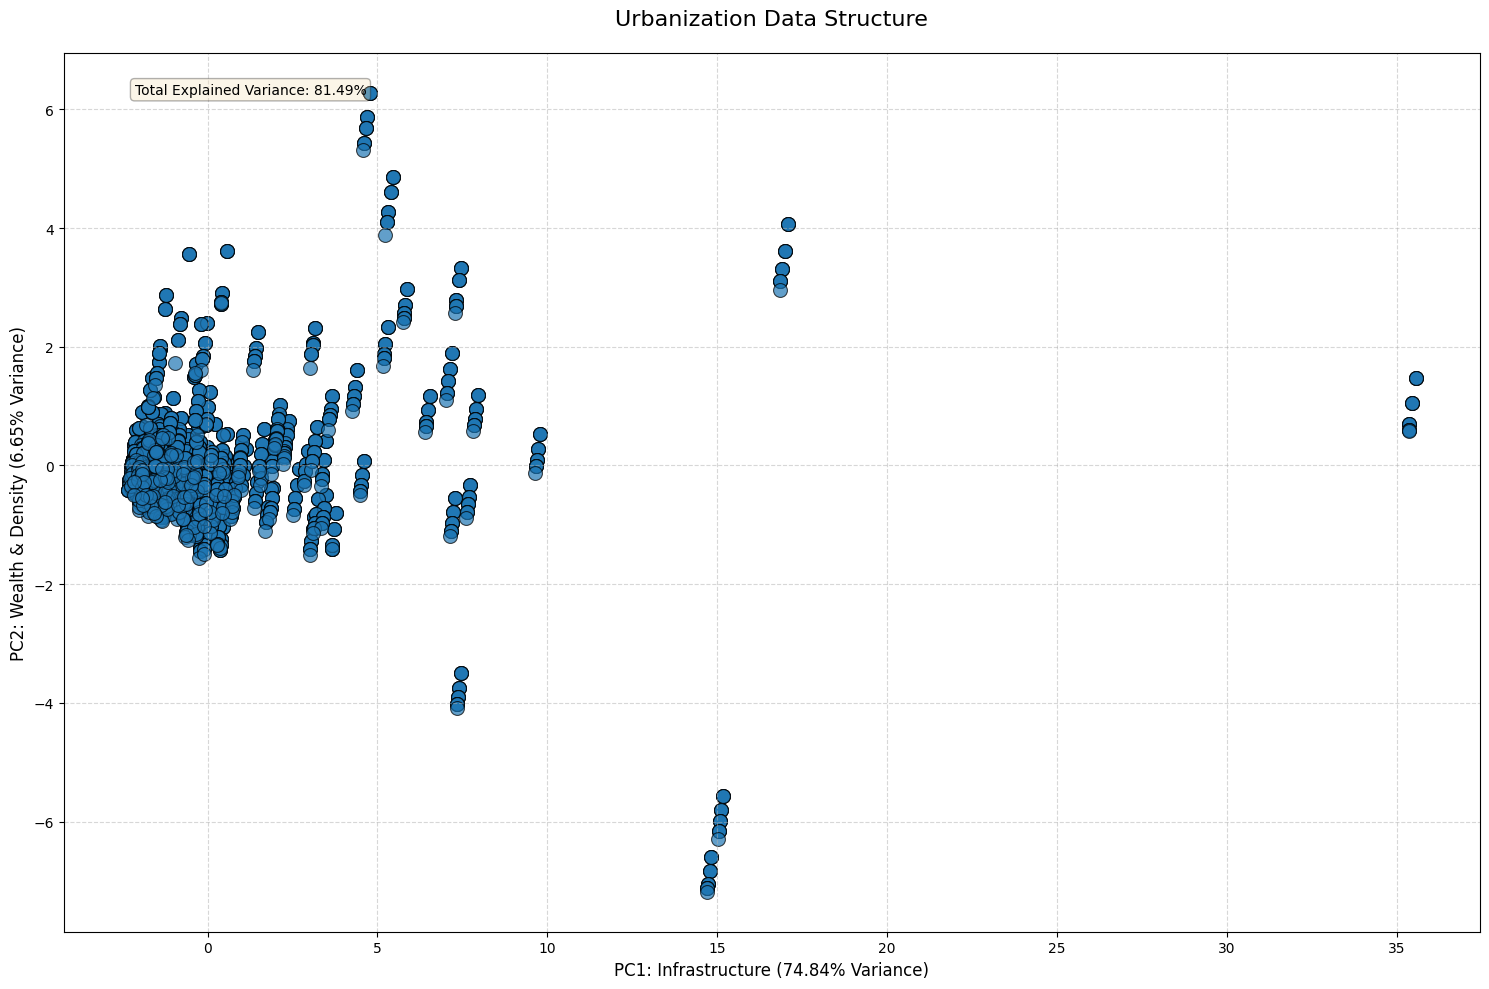

In [88]:
fig = pca_engine.plot_projection()
fig.show()

### Reasoning of the choice of the clustering algorithm

Since we've seen that there's no significant difference between years, we'll take the data from 2022 to obtain the clusters. 

2025-12-13 22:46:35,375 - INFO - Starting K-Means tuning for k=2 to 10...


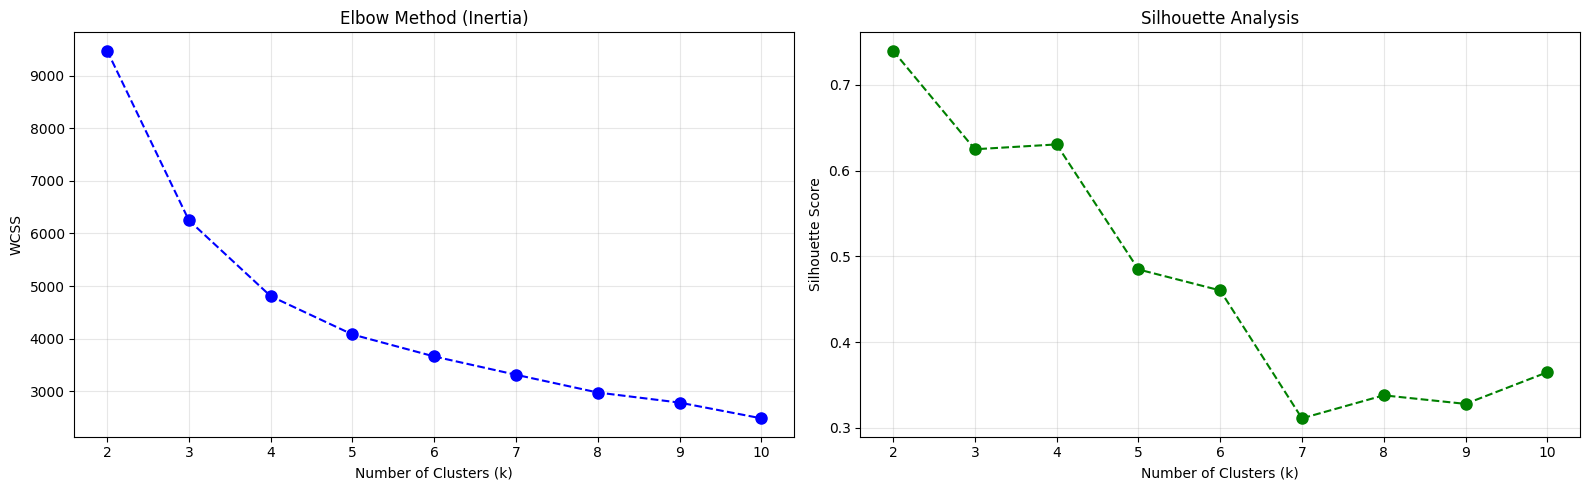

In [89]:
engine = ClusteringEngine(seed=RANDOM_SEED, model_dir=config["model_dir"])
engine.preprocess(df2022[config["features"]])
fig_tune, metrics = engine.run_kmeans_tuning(max_k=10)
fig_tune.show()

From the plots above we see that the optimal number of clusters should be between 3 and 6 clusters. 3 corresponds to the initial assumption about the existance of the natural 3 clusters like city, town and village.

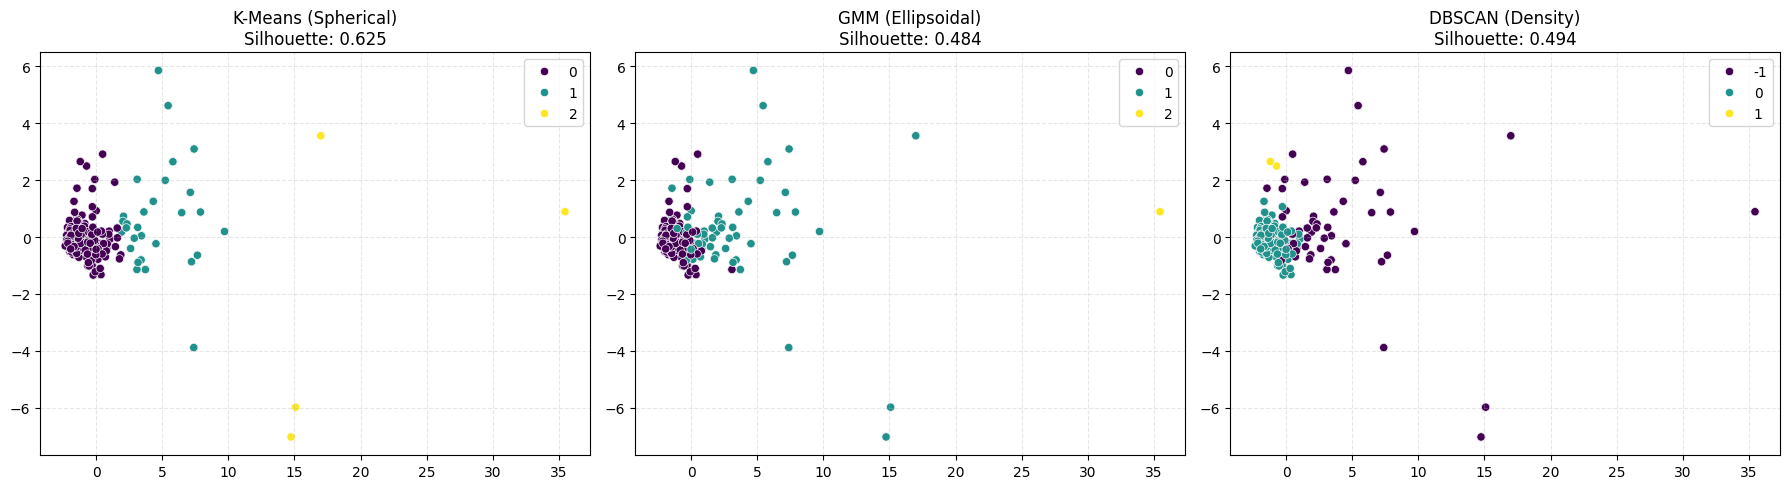

In [90]:
pca_df = pca_engine.run_pca(df2022)
pca_coords = pca_df.values
fig_compare = engine.compare_algorithms(pca_data=pca_coords)
plt.show()

### CHOICE OF THE NUMBER OF CLUSTERS

In [91]:
for exp in config["experiments"]:
    k = exp["n_clusters"]
    name = exp["model_name"]
    engine.train_model(n_clusters=k, model_name=name)

2025-12-13 22:46:36,615 - INFO - Training KMeans model with n=3...
2025-12-13 22:46:36,638 - INFO - Model saved to D:\projects\uni\FCD final\models\urban_kmeans_3.joblib
2025-12-13 22:46:36,639 - INFO - Training KMeans model with n=4...
2025-12-13 22:46:36,663 - INFO - Model saved to D:\projects\uni\FCD final\models\urban_kmeans_4.joblib
2025-12-13 22:46:36,663 - INFO - Training KMeans model with n=5...
2025-12-13 22:46:36,687 - INFO - Model saved to D:\projects\uni\FCD final\models\urban_kmeans_5.joblib
2025-12-13 22:46:36,688 - INFO - Training KMeans model with n=6...
2025-12-13 22:46:36,715 - INFO - Model saved to D:\projects\uni\FCD final\models\urban_kmeans_6.joblib


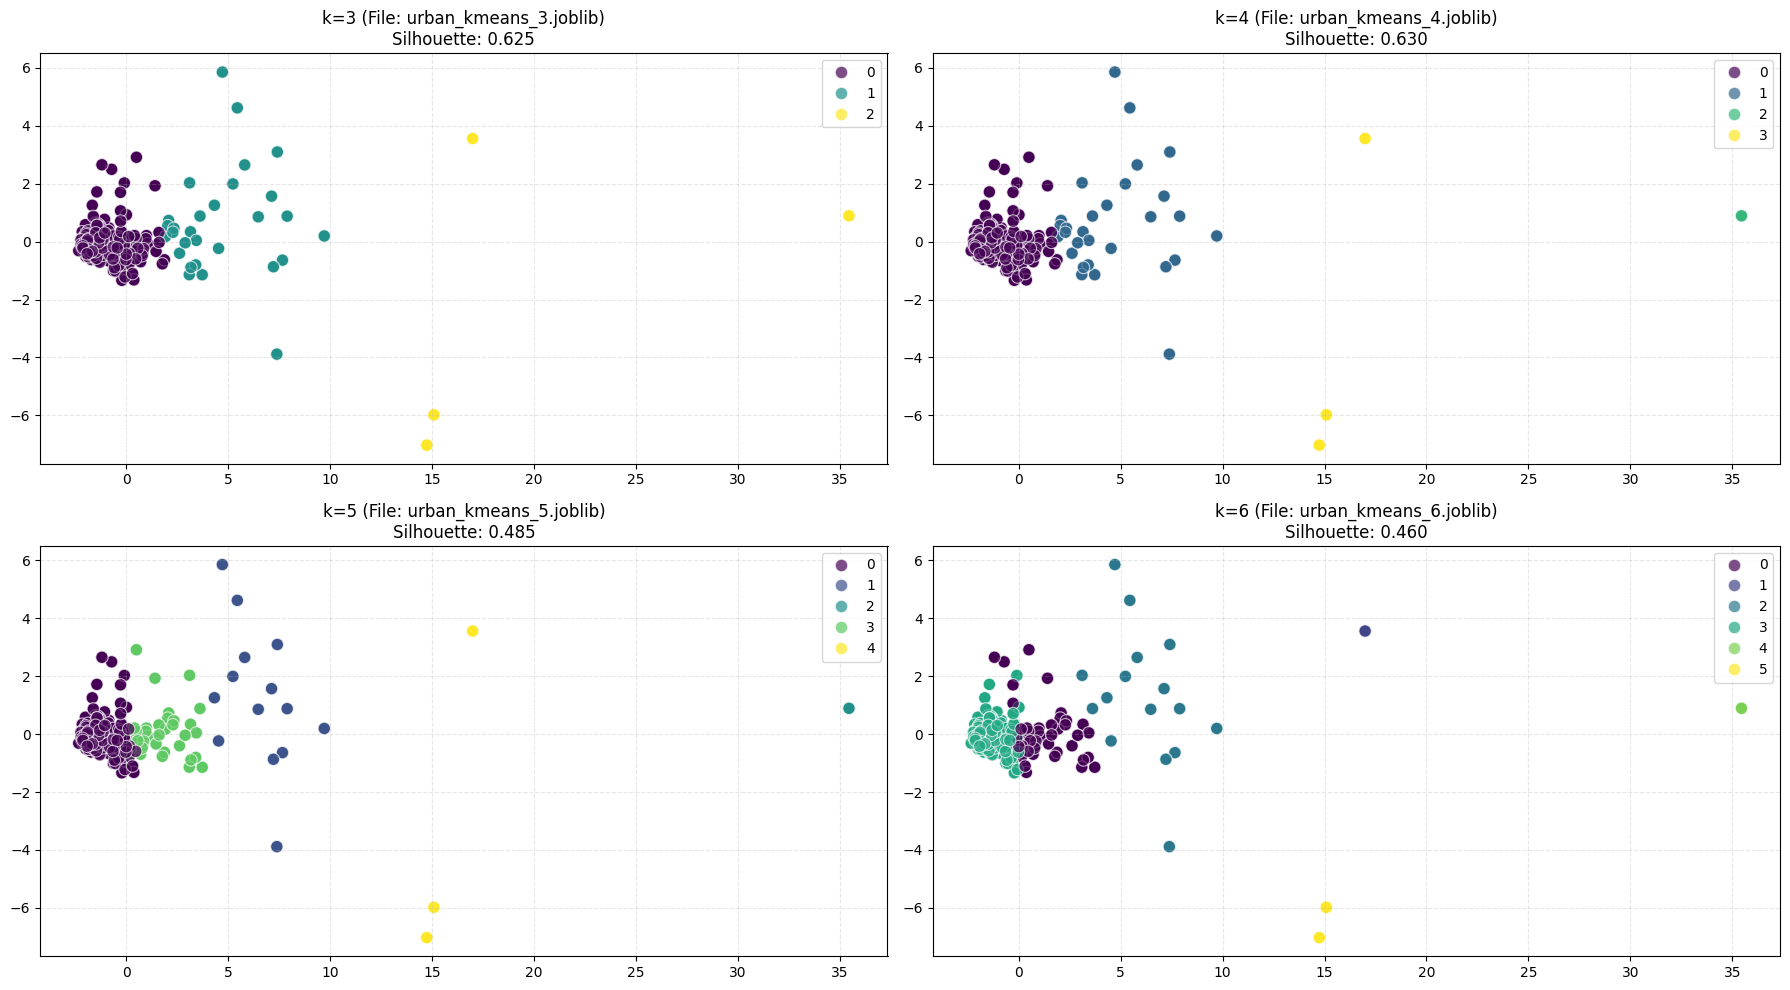

In [92]:
engine.plot_saved_cluster_models(pca_data=pca_coords).show()

In [93]:
profiles = engine.get_cluster_profiles(df2022, config["features"])
print("\nCluster Profiles (Feature Means):")
profiles


Cluster Profiles (Feature Means):


,Count,people/km2,avg_income,cinema,college,courthouse,fire_station,hospital,kindergarten,library,mall,museum,pharmacy,police,post_office,school,station,theatre,university
Cluster,,,,,,,,,,,,,,,,,,,
0,180,283.84,1263.01,1.60,0.84,2.22,4.98,3.18,26.22,4.20,4.82,9.67,23.36,8.29,8.69,69.38,9.58,4.80,2.2
1,4,5867.10,1628.70,8.00,11.00,11.00,8.00,20.00,72.00,20.00,39.00,72.00,119.00,36.00,30.00,213.00,53.00,24.00,43.0
2,64,1963.42,1371.28,2.94,1.88,3.75,8.69,7.81,66.94,9.38,19.94,20.94,62.94,17.19,19.56,154.31,21.19,10.75,8.5
3,672,127.35,1072.34,0.45,0.05,0.73,1.95,0.78,6.12,1.65,0.68,3.79,5.78,3.12,2.79,18.60,2.12,1.27,0.2
4,4,5572.40,1856.30,14.00,16.00,15.00,25.00,39.00,189.00,88.00,55.00,109.00,351.00,74.00,69.00,431.00,103.00,77.00,53.0
5,8,90.20,1196.60,7.50,8.50,13.50,31.50,13.50,76.50,27.50,9.50,72.00,105.00,56.00,47.50,261.50,33.00,23.50,10.0


In [94]:
# df_clean = DataLoader(MASTER_DF_FILE).get_data_for_year(year=2022, features=config["cluster_profile"])
# profiles = engine.get_cluster_profiles(df_clean, features=config["features"])

# print("--- Cluster Profiles ---")
# # Pro Tip: If in Jupyter, use .style to make it readable
# display(profiles.style.background_gradient(cmap='Blues', subset=config["cluster_profile"]))


# # 2. See Who is in Which Cluster
# # Shows you: "Cluster 0 contains: [Aveiro, Coimbra, ...]"
# members = engine.get_cluster_members(df_clean, name_column="municipality")